# Load class and import library

In [205]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import linalg
from sklearn.linear_model import  Lasso, LassoCV,ElasticNet,ElasticNetCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE,SelectFromModel

# Make elastic net outshine than lasso


In the course, we have seen that elastic net is more stable than lasso in terms of feature selection, especially for linear models with highly correlated features.

To demonstrate it experimentally, we try to creat a dataset with highly correlated variables at first.Based on the data generator used by TP, we have added parameters(**seperate_level**) that control the generation of linear features. This parameter makes in n given features, each seperate-level feature is completely linearly related, which means:

$$[X_1, X_2...X_{seperate-level}...X_n]\Rightarrow[X_1, X_1*(-1)^1, X_1*(-1)^2...X_1*(-1)^{seperate-level}, X_2, X_2*(-1)^1....]$$

We also scaled all the generated features with $Maxminscale$ to make feature selection more obvious.



In [206]:
class NewEvent:
    def __init__(self, n_features=10, coefficients=None, tail_strength=0.1,
                 effective_rank=None, bias=0.0, noise_level=None,seperate_level=5):
        self.n_features = n_features
        self.noise_level = noise_level
        self.effective_rank = effective_rank
        self.seperate_level = seperate_level

        if coefficients is None:
            self.coefficients = 10 * np.random.randn(n_features)
        else:
            self.coefficients = coefficients

        v, _ = linalg.qr(np.random.randn(n_features, n_features), mode='economic')
        self._v = v

        # Index of the singular values
        singular_ind = np.arange(n_features, dtype=np.float64)

        if self.effective_rank is None:
            tail_strength = 1
            self.effective_rank = n_features
            singular_ind = 10 * singular_ind

        # Build the singular profile by assembling signal and noise components
        low_rank = ((1 - tail_strength) *
                    np.exp(-1.0 * (singular_ind / self.effective_rank) ** 2))
        tail = tail_strength * np.exp(-0.1 * singular_ind / self.effective_rank)
        self._s = np.identity(n_features) * (low_rank + tail)

    def sample(self, n_samples=100):
        # we create an n_samples*n_features matrix of zero to initialize X
        X = np.zeros((n_samples, self.n_features))
        # u0 is the matrix we used to build the variable with high correlation
        u0 = np.random.randn(n_features//seperate_level+1,n_samples)*100
        for i in range(self.n_features):
            X[:,i]=u0[i//self.seperate_level]*((-1)**i)
            if self.noise_level:
                X[:,i] += np.random.normal(0,self.noise_level,n_samples)
        y = np.dot(X, self.coefficients) + np.random.normal(0,self.noise_level,n_samples)
        # When some variables are highly correlated and on the same scale, The elastic net perform better. So we set the data on the same scale
        min_max_scaler = MinMaxScaler() 
        X = min_max_scaler.fit_transform(X)
        y = np.dot(X,self.coefficients)
        coeffs_norm = linalg.norm(self.coefficients)
        y += self.noise_level / 100 * coeffs_norm * np.random.randn(len(y))
        
        return X, y

# Create test data

In [207]:
n_features=10
seperate_level=4
noise_level=2
event = NewEvent(n_features=n_features,seperate_level=seperate_level,noise_level=noise_level)
X, y = event.sample(n_samples=1000)

# correlation validation
In order to check the correlation of the data, we use the heatmap in seaborn to test. It is obvious in the figure that because we have selected "seperate_level" as 4, that means we divide every four data sets into a set of linearly related variables.

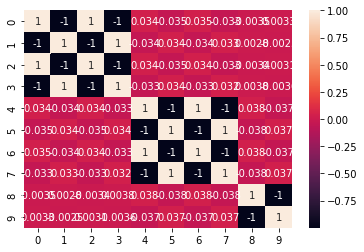

In [208]:
sns.heatmap(np.corrcoef(X.T),annot = True)

Compute the best parameter for Lasso and Elastic Net

In [209]:
lasso_alpha = LassoCV(cv=5, random_state=0).fit(X, y).alpha_ 
print('Best alpha for lasso is %f' % lasso_alpha)

ElasticNetCV_alpha = ElasticNetCV(cv=5, random_state=0).fit(X,y).alpha_
ElasticNetCV_l1_ratio = ElasticNetCV(cv=5, random_state=0).fit(X,y).l1_ratio_
print('Best alpha for ElasticNet is %f' % ElasticNetCV_alpha)
print('Best l1_ratio for ElasticNet is %f' % ElasticNetCV_l1_ratio)

Best alpha for lasso is 0.000313
Best alpha for ElasticNet is 0.000627
Best l1_ratio for ElasticNet is 0.500000


# Compare the feature selected by elastic net and by lasso in 100 times
In order to compare the feature selected by elastic net and by lasso, we use event to generate **100 times** sample each containing **1000 samples**. And then we select the features of the matched model through the ***SelectFromModele*** library. At the same time, we note down the features each time the model is selected in order to see which features are selected more frequently.

In [210]:
ntimes = 100
lasso_selected_feature = []
elastic_net_selected_feature = []

# ntimes's samples
for i in range(ntimes):
    X, y = event.sample(n_samples=1000)
    selector_lasso = SelectFromModel(Lasso(alpha=lasso_alpha,max_iter = 10000)).fit(X, y)
    lasso_selected_feature.append(selector_lasso.get_support())
    selector_EN = SelectFromModel(ElasticNet(alpha=ElasticNetCV_alpha,l1_ratio=ElasticNetCV_l1_ratio,max_iter = 10000)).fit(X, y)
    elastic_net_selected_feature.append(selector_EN.get_support())

# Comparasion of histogramme

Text(0.5, 1.0, 'feature selected by Elastic Net')

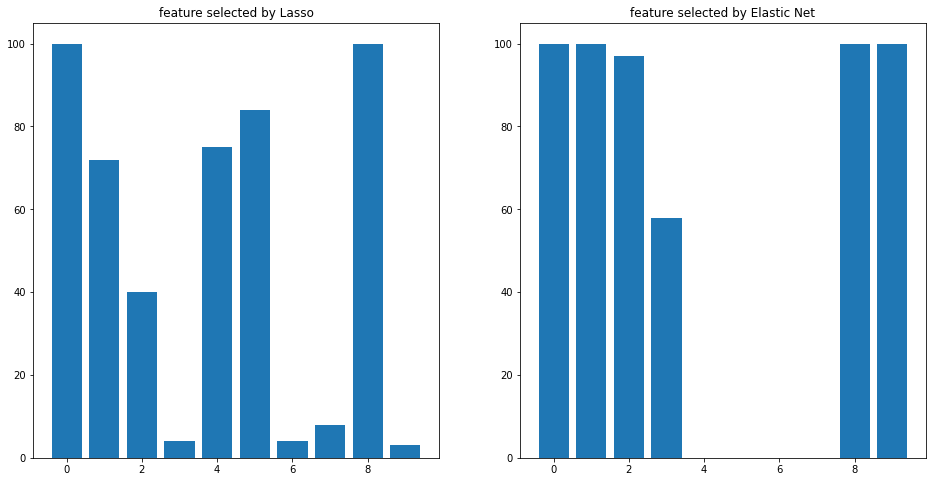

In [211]:
plt.figure(figsize=(16,8))
# plot hist of feature selected by Lasso model
plt.subplot(1,2,1)
count_lasso = [0 for _ in range(n_features)]
for i in range(len(lasso_selected_feature)):
    for j in range(len(lasso_selected_feature[0])):
        if lasso_selected_feature[i][j]==True:
            count_lasso[j]+=1
plt.bar(x=range(n_features),height=count_lasso)
plt.title("feature selected by Lasso")

#plot hist of feature selected by Elastic net model
plt.subplot(1,2,2)
count_en = [0 for _ in range(n_features)]
for i in range(len(elastic_net_selected_feature)):
    for j in range(len(elastic_net_selected_feature[0])):
        if elastic_net_selected_feature[i][j]==True:
            count_en[j]+=1
plt.bar(x=range(n_features),height=count_en)
plt.title("feature selected by Elastic Net")

The features selected by the lasso model are **unstable**: the same feature may not all be selected or ignored under different sampling. While the elastic net model is more stable since some certain features are always selected.